# Post-processing to improve CT image quality

import necessary packages

In [ ]:
import torch
print(torch.__version__)
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

2.1.0+cu118


Set to use GPU, check is output is 'cuda'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device:{device}")

Using device:cuda


**For Colab user**:

Option 1: To access the training files, please follow the instructions:


1.   Save the [folder](https://drive.google.com/drive/folders/1larjCPxZ-e33B3UjjhiBUG0OAyF19aj3?usp=drive_link) to your own google drive by "**Add to My Drive**" in the opened links
2.   Use the **code block below** to mount the files with the directory in your drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!cp "/content/drive/MyDrive/MLtutorial@Lorentz/recon_low.npy" "./recon_low.npy"
!cp "/content/drive/MyDrive/MLtutorial@Lorentz/recon_high.npy" "./recon_high.npy"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Option 2:
 **Warning!** This is often slower and dependent on the internet connection! Only consider it when the first option doesn't work

1.  Clone the files from github repostory [MLtutorial@Lorentz](https://github.com/jiayangshi/MLtutorial-Lorentz)
2.   Use the **code block below** to upload the files to current colab notebook



In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving recon_high.npy to recon_high.npy
Saving recon_low.npy to recon_low.npy
User uploaded file "recon_high.npy" with length 67108992 bytes
User uploaded file "recon_low.npy" with length 67108992 bytes


load the low- and high-dose reconstructions

In [ ]:
recon_low = np.load('recon_low.npy')
recon_high = np.load('recon_high.npy')

print(f"Shape of recon_low: {recon_low.shape}")
print(f"Shape of recon_high: {recon_high.shape}")

Shape of recon_low: (256, 256, 256)
Shape of recon_high: (256, 256, 256)


plot the low- and high-dose reconstructions

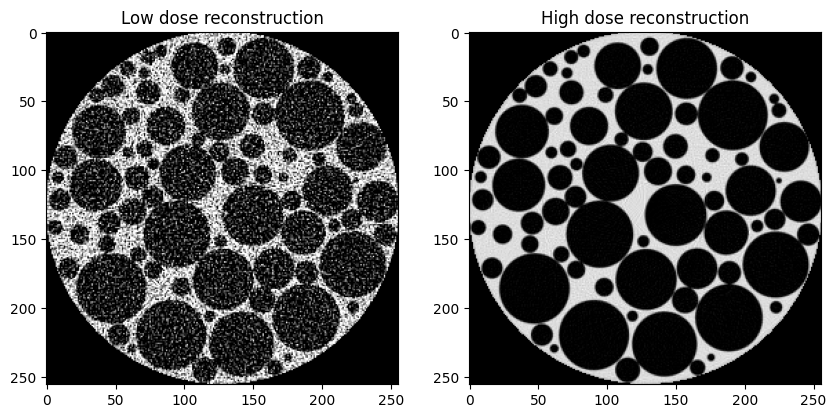

In [ ]:
# Plot the reconstructions
idx = 10 # slice nr

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(recon_low[idx], cmap='gray')
plt.title('Low dose reconstruction')
plt.subplot(1, 2, 2)
plt.imshow(recon_high[idx], cmap='gray')
plt.title('High dose reconstruction')
plt.show()

Define the neural network for post processing, we build an simple encoder-decoder arichteture from scratch here, which has 3 layers of down- and upsampling convolution layers

In [ ]:
class Net(nn.Module):
    def __init__(self, interm_channels=32):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=interm_channels,
                               kernel_size=3,
                               stride=2,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=interm_channels,
                               out_channels=interm_channels*2,
                               kernel_size=3,
                               stride=2,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=interm_channels*2,
                               out_channels=interm_channels*4,
                               kernel_size=3,
                               stride=2,
                               padding=1)
        self.relu = nn.ReLU()
        self.convtrans1 = nn.ConvTranspose2d(in_channels=interm_channels*4,
                                             out_channels=interm_channels*2,
                                             kernel_size=2,
                                             stride=2)
        self.convtrans2 = nn.ConvTranspose2d(in_channels=interm_channels*2,
                                                out_channels=interm_channels,
                                                kernel_size=2,
                                                stride=2)
        self.convtrans3 = nn.ConvTranspose2d(in_channels=interm_channels,
                                                out_channels=1,
                                                kernel_size=2,
                                                stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        x = self.relu(self.convtrans1(x))
        x = self.relu(self.convtrans2(x))
        x = self.convtrans3(x)
        x = self.sigmoid(x)
        return x

In [ ]:
#Function to count the number of trainable parameters in a pytorch model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
model = Net(interm_channels=64)

print(f"Total trainable number of parameters: {count_parameters(model)}")

# move model to GPU
model = model.to(device)


Total trainable number of parameters: 533953


add additional dimension for channel for recon_low and recon_high
(256,256,256): (slices, height, width) -> (256,1,256,256): (slices, channel, height, width)

for CT images, the channel is typically 1;
for RGB images, the channel is typically 3

In [ ]:
recon_low = np.expand_dims(recon_low, axis=1)
recon_high = np.expand_dims(recon_high, axis=1)

print(f"shape of recon_low: {recon_low.shape}")
print(f"shape of recon_high: {recon_high.shape}")

shape of recon_low: (256, 1, 256, 256)
shape of recon_high: (256, 1, 256, 256)


recon_low/recpn_high in shape (256,256,256)
we split the upper 128 slices for training and lower 128 slices for testing
put them into GPU

In [ ]:
train = (torch.tensor(recon_low[:128].copy()).to(device),torch.tensor(recon_high[:128].copy()).to(device))
test = (torch.tensor(recon_low[128:].copy()).to(device),torch.tensor(recon_high[128:].copy()).to(device))

define the loss function and optimizer

In [ ]:
mse_loss = nn.MSELoss()


epoch is the number of iterations that goes through all training data

100%|██████████| 128/128 [00:00<00:00, 325.12it/s]


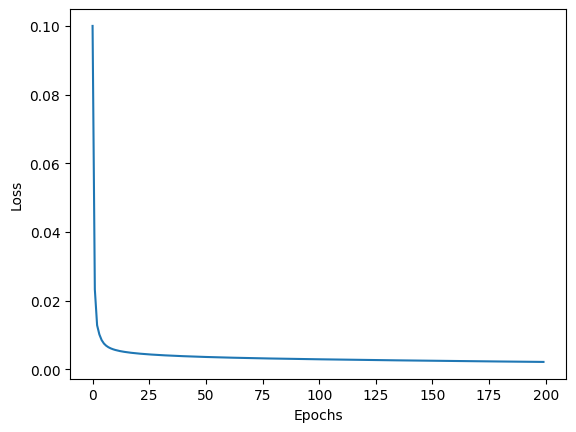

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 200
train_loss = []

for e in range(epochs):
    cur_loss = 0
    for i in tqdm(range(train[0].shape[0])):
        # add additional dimension for batch
        # (batch_size=1, channels, height, width)
        x = train[0][i].unsqueeze(0)
        y = train[1][i].unsqueeze(0)
        y_hat = model(x)
        loss = mse_loss(y_hat, y)
        cur_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Reset the gradients
        optimizer.zero_grad()
    train_loss.append(cur_loss/train[0].shape[0])

plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

the model is trained, let's check how good model is trained to fit the training data

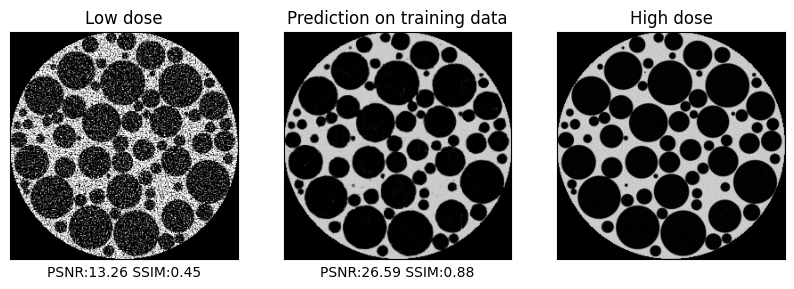

In [ ]:
x = train[0][0].unsqueeze(0)
y = train[1][0].unsqueeze(0)

pred = model(x)


plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(x.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Low dose')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(x.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(x.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Prediction on training data')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(pred.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(pred.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 3)
plt.imshow(y.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('High dose')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.show()

How does the trained model work on unseen test data

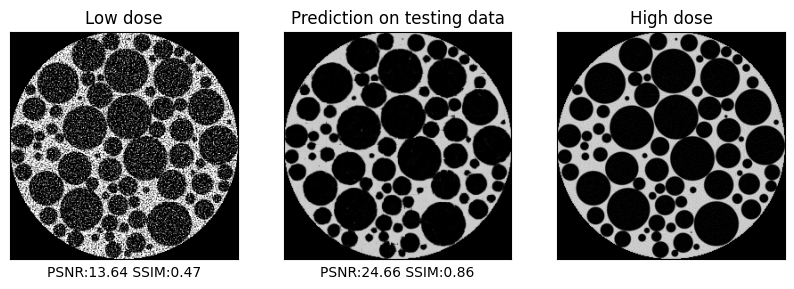

In [ ]:
# the index of test images
idx = -1

x = test[0][idx].unsqueeze(0)
y = test[1][idx].unsqueeze(0)

pred = model(x)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(x.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Low dose')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(x.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(x.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Prediction on testing data')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(pred.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(pred.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 3)
plt.imshow(y.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('High dose')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.show()

It worked well on training data, but not on test data
Overfitting, too much fited into training data, so it doesn't generalize well on unseen data
solution: validation during training

In [ ]:
train = (torch.tensor(recon_low[:128].copy()).to(device),torch.tensor(recon_high[:128].copy()).to(device))
valid = (torch.tensor(recon_low[128:192].copy()).to(device),torch.tensor(recon_high[128:192].copy()).to(device))
test = (torch.tensor(recon_low[192:].copy()).to(device),torch.tensor(recon_high[192:].copy()).to(device))

reinstance the model and optmizer as they are optimized

In [ ]:
model = Net(interm_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


100%|██████████| 128/128 [00:00<00:00, 296.79it/s]


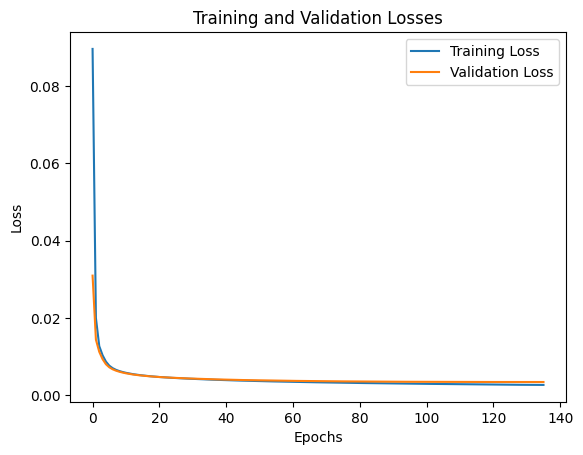

In [ ]:
epochs = 200
train_loss = []
valid_loss = []

for e in range(epochs):
    cur_loss = 0
    cur_valid_loss = 0
    for i in tqdm(range(train[0].shape[0])):
        # add additional dimension for batch
        # (batch_size=1, channels, height, width)
        x = train[0][i].unsqueeze(0)
        y = train[1][i].unsqueeze(0)
        y_hat = model(x)
        loss = mse_loss(y_hat, y)
        cur_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Reset the gradients
        optimizer.zero_grad()
    train_loss.append(cur_loss/train[0].shape[0])
    # Validation, no need to backpropagate
    with torch.no_grad():
        for i in range(valid[0].shape[0]):
            x = valid[0][i].unsqueeze(0)
            y = valid[1][i].unsqueeze(0)
            y_hat = model(x)
            loss = mse_loss(y_hat, y)
            cur_valid_loss += loss.item()
    valid_loss.append(cur_valid_loss/valid[0].shape[0])

    if valid_loss[-1] == min(valid_loss):
        torch.save(model.state_dict(), 'best_model.pth')
    # early stop, if current valid loss > max of last 5 valid losses
    if e > 20 and valid_loss[-1] > max(valid_loss[-2-5:-2]):
        break

plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

load best weights

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

Let's check again the performance on training and testing data

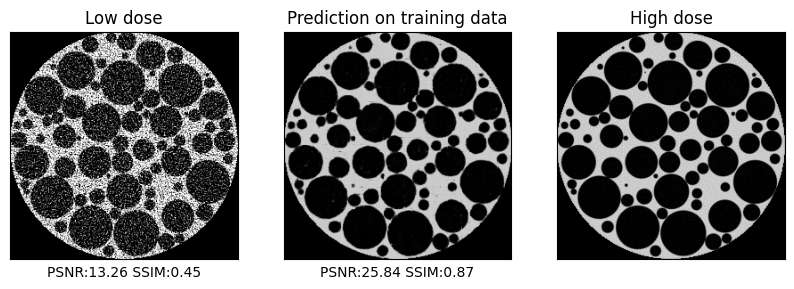

In [ ]:
x = train[0][0].unsqueeze(0)
y = train[1][0].unsqueeze(0)

pred = model(x)


plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(x.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Low dose')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(x.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(x.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Prediction on training data')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(pred.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(pred.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 3)
plt.imshow(y.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('High dose')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.show()

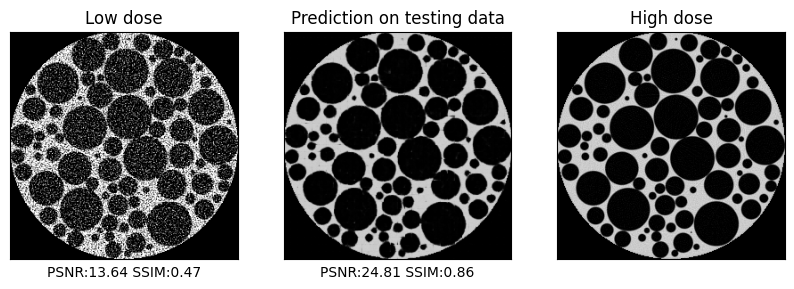

In [ ]:
# the index of test images
idx = -1

x = test[0][idx].unsqueeze(0)
y = test[1][idx].unsqueeze(0)

pred = model(x)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(x.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Low dose')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(x.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(x.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Prediction on testing data')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(pred.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(pred.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 3)
plt.imshow(y.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('High dose')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.show()

TV regularization

In [ ]:
def TV_loss(img):
    """
    Compute total variation loss.
    Args:
    - img: PyTorch Variable, shape [1, 1, H, W] holding an input image.
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
            for img.
    """
    # Shift one pixel and get difference (for both x and y directions)
    x_diff = img[:, :, 1:, :] - img[:, :, :-1, :]
    y_diff = img[:, :, :, 1:] - img[:, :, :, :-1]

    # Compute the total variation (sum of the L2 norm over all differences)
    tv_loss = ((x_diff**2).sum() + (y_diff**2).sum())/torch.numel(x_diff)
    return tv_loss


In [ ]:
model = Net(interm_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

100%|██████████| 128/128 [00:00<00:00, 266.58it/s]


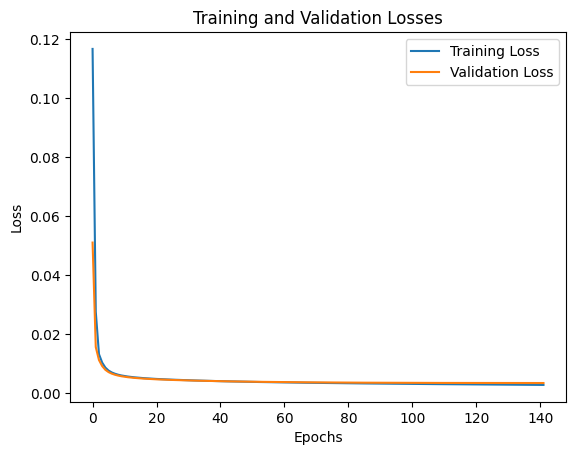

In [ ]:
epochs = 200
train_loss = []
valid_loss = []

for e in range(epochs):
    cur_loss = 0
    cur_valid_loss = 0
    for i in tqdm(range(train[0].shape[0])):
        # add additional dimension for batch
        # (batch_size=1, channels, height, width)
        x = train[0][i].unsqueeze(0)
        y = train[1][i].unsqueeze(0)
        y_hat = model(x)
        loss = mse_loss(y_hat, y) + 0.005*TV_loss(y_hat)
        cur_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Reset the gradients
        optimizer.zero_grad()
    train_loss.append(cur_loss/train[0].shape[0])
    # Validation, no need to backpropagate
    with torch.no_grad():
        for i in range(valid[0].shape[0]):
            x = valid[0][i].unsqueeze(0)
            y = valid[1][i].unsqueeze(0)
            y_hat = model(x)
            loss = mse_loss(y_hat, y)
            cur_valid_loss += loss.item()
    valid_loss.append(cur_valid_loss/valid[0].shape[0])

    if valid_loss[-1] == min(valid_loss):
        torch.save(model.state_dict(), 'best_model.pth')
    # early stop, if current valid loss > max of last 5 valid losses
    if e > 20 and valid_loss[-1] > max(valid_loss[-2-5:-2]):
        break

plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

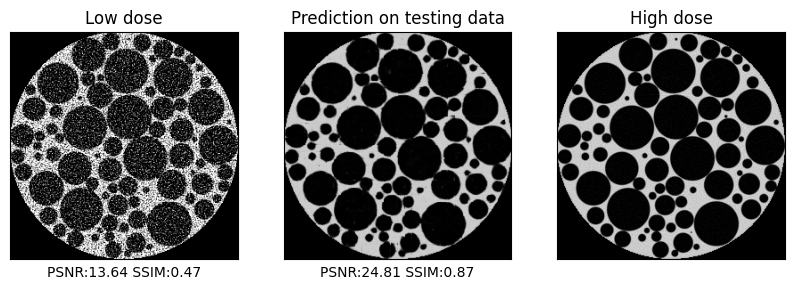

In [ ]:
# the index of test images
idx = -1

x = test[0][idx].unsqueeze(0)
y = test[1][idx].unsqueeze(0)

pred = model(x)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(x.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Low dose')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(x.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(x.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('Prediction on testing data')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(pred.cpu().detach().numpy(),y.cpu().detach().numpy(),data_range=1):.2f} SSIM:{ssim(pred.cpu().detach().numpy()[0,0],y.cpu().detach().numpy()[0,0],data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 3)
plt.imshow(y.squeeze().cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('High dose')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.show()